## Amazon Fine Food Review - Ensemble Algorithm

In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import seaborn as sns

C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [31]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 40000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [32]:
filtered_data['Score'].value_counts()

1    33439
0     6561
Name: Score, dtype: int64

In [33]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [34]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(37415, 10)

In [35]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.5375

In [36]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [37]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(37415, 10)


1    31324
0     6091
Name: Score, dtype: int64

In [38]:
final_score = final['Score']
final_score.shape

(37415,)

In [39]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [40]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [41]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 37415/37415 [00:33<00:00, 1133.06it/s]


## 1) Applying XGBoost

## 1.1) Applying XGBoost on BOW, SET 1

In [114]:
# Getting all the imports done

from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
import xgboost as xgb

In [14]:
from sklearn.model_selection import GridSearchCV

In [196]:
final['Cleaned_Text']=preprocessed_reviews
final['Word Count'] = final['Cleaned_Text'].apply(lambda x:len(x.split()))
#final['Summary Word Count'] = final['Cleaned_Summary'].apply(lambda x:len(x.split()))
final_review = final[['Cleaned_Text','Word Count','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [197]:
# Time Series Split

X_1_train, X_test, Y_1_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
#X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(29932, 2) (29932,)


In [44]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [45]:
df_post_split['Score'].value_counts()

1    25184
0     4748
Name: Score, dtype: int64

In [47]:
x_negative_downsample = resample(x_negetive,replace=True,n_samples=20000,random_state=123) 

In [48]:
print(x_negative_downsample.shape, type(x_positive))

(20000, 2) <class 'pandas.core.frame.DataFrame'>


In [49]:
df_upsample = pd.concat([x_positive,x_negative_downsample])
type(df_upsample)
df_upsample.head()

,Cleaned_Text,Score
0,really good idea final product outstanding use...,1
1,received shipment could hardly wait try produc...,1
2,love stuff sugar free rot gums tastes good goi...,1
3,nothing product bother link top page buy used ...,1
4,fresh limes underappreciated joy kitchen squir...,1


In [50]:
df_upsample['Score'].value_counts()

1    25184
0    20000
Name: Score, dtype: int64

In [51]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_1_train = df_upsample['Score']
print(X_Train.shape, Y_1_train.shape)

(45184, 1) (45184,)


In [54]:
# Creating Tfidf Vectorizer

bow_vect = CountVectorizer(ngram_range=(1,2) , min_df = 10)
D1_Train = bow_vect.fit_transform(X_Train['Cleaned_Text'])
D1_Test = bow_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", bow_vect.get_feature_names()[0:10])
print(D1_Train.shape,D1_Test.shape)

Some feature names :  ['aa', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able afford', 'able buy', 'able chew', 'able drink']
(45184, 33079) (7483, 33079)


In [55]:
n_train = D1_Train.get_shape()[0]
n_test = D1_Test.get_shape()[0]
print(n_train)
print(n_test)

45184
7483


In [56]:
tuned_param = [{'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
               'n_estimators':[5, 10, 50, 100, 200, 500]
               }]

In [62]:
# Using GridSearchCV
xgb = xgb.XGBClassifier(random_state = 0,n_jobs = 4, verbosity = 2)
bow_model = GridSearchCV(xgb,tuned_param,cv = 3, scoring = 'roc_auc')
bow_model.fit(D1_Train,Y_1_train)

print(bow_model.best_estimator_)
print("AUC SCORE : ",bow_model.score(D1_Test,Y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbosity=2)
AUC SCORE :  0.9330696505708208


In [63]:
results = bow_model.cv_results_
print(results)

{'mean_fit_time': array([  1.45543726,   1.62551697,   5.15933975,   9.90716974,
        19.16528551,  45.91113742,   1.25018255,   1.83189933,
         6.73984639,  14.04567806,  28.37168582,  73.52599883,
         1.40740752,   2.17794061,   9.95424167,  19.73330943,
        39.22437994, 101.45855538,   1.65107322,   3.02202527,
        13.84495099,  26.28695107,  55.01459837, 135.63493268,
         1.85863074,   3.38194696,  17.89170845,  32.50212097,
        66.81972615, 135.99586948,   1.93280657,   3.20413701,
        15.75953205,  30.34493073,  60.27233251, 152.60679046,
         2.27392006,   3.82831478,  18.85953013,  36.62598944,
        71.05917875, 175.39241465,   2.31854479,   4.10864377,
        20.73614526,  40.54244916,  81.43032614, 202.46608528,
         2.95108795,   5.5806481 ,  25.30768911,  54.44738372,
       109.8996098 , 279.85722375]), 'std_fit_time': array([3.83126835e-01, 2.66498338e-02, 8.48871392e-02, 4.56042081e-01,
       4.29056448e-01, 2.14916555e+00, 

       2.14899554e-04, 3.73531924e-05])}


In [64]:
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
Y_axis = np.array(results['param_max_depth'].data, dtype=float)

Text(0.5,1,'Train AUC HeatMap')

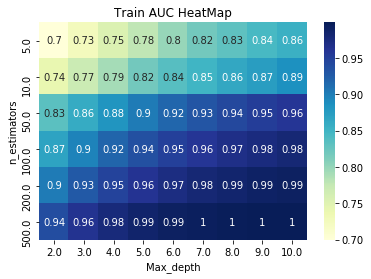

In [65]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('Train AUC HeatMap')

Text(0.5,1,'CV AUC HeatMap')

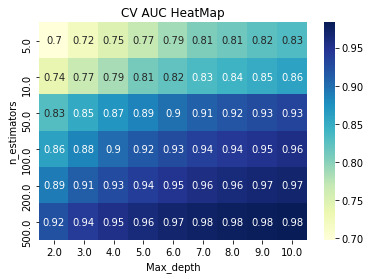

In [66]:
pvt_test = pd.pivot_table(pd.DataFrame(results),values='mean_test_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('CV AUC HeatMap')

In [69]:
# Fitting the model on test data

test_neigh = xgb.XGBClassifier(random_state = 0,max_depth = 6, n_estimators = 500, n_jobs = 4, verbosity = 3)
#test_neigh.set_params(**best_paramList)
test_neigh.fit(D1_Train,Y_1_train)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

7483
7483
Algo Run Successfully on D_Test


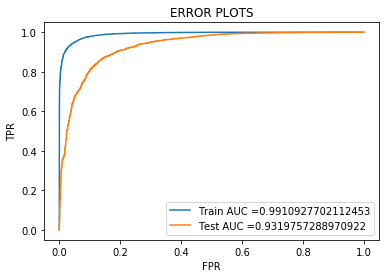

In [70]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [71]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
18935 1065 1200 23984
[[18935  1065]
 [ 1200 23984]]
Test Confusion Matrix
1020 323 458 5682
[[1020  323]
 [ 458 5682]]


Text(0.5,1,'Confusion Matrix of Train Data')

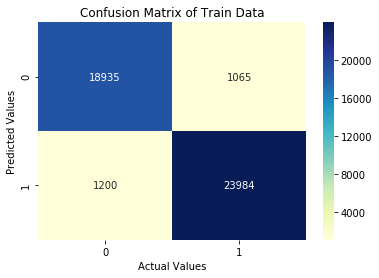

In [72]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

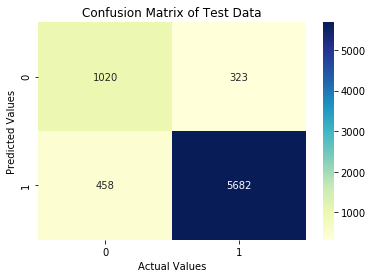

In [73]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

In [74]:
importances = test_neigh.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features = bow_vect.get_feature_names()
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[ 7339 17158 21189 24158 12957 32543  7748 18510 13834  1684 28989  9487
  1814 13979 31617  2420  8563 32403  8528  7788]
     Feature Name  Feature Importance
0       delicious            0.006834
1           loves            0.006153
2         perfect            0.005930
3          return            0.005633
4           great            0.005452
5           worst            0.005290
6    disappointed            0.005211
7           money            0.005022
8          highly            0.004765
9           awful            0.004527
10       terrible            0.004488
11      excellent            0.004229
12            bad            0.004139
13       horrible            0.004135
14          waste            0.004019
15           best            0.003744
16           easy            0.003650
17      wonderful            0.003559
18     earth best            0.003510
19  disappointing            0.003433


In [75]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt

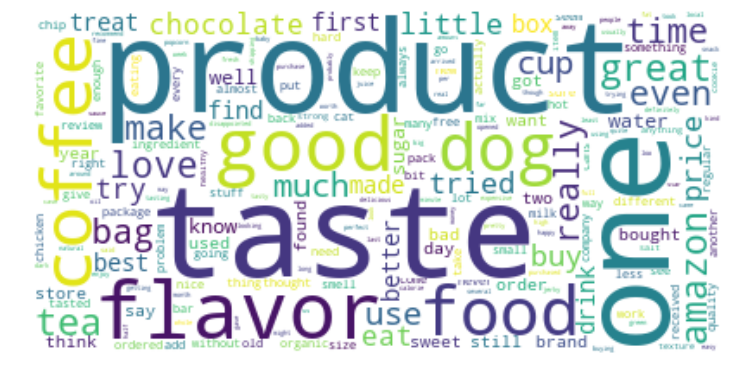

In [76]:
bow_features = " ".join(features)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 1.2) Applying XGBoost on TFIDF, SET 2

###### We are using simple loops for CV . Hence we manually upsampled the training data. The code for this is present under Set 3.

In [230]:
# Creating Tfidf Vectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 10)
D2_Train = tfidf_vect.fit_transform(X_Train['Cleaned_Text'])
D2_Cv = tfidf_vect.transform(X_1_cv['Cleaned_Text'])
D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", tfidf_vect.get_feature_names()[0:10])
print(D2_Train.shape,D2_Test.shape)

Some feature names :  ['aa', 'abandoned', 'abdominal', 'abide', 'abide half', 'ability', 'able', 'able add', 'able afford', 'able buy']
(38308, 30974) (7483, 30974)


In [231]:
n_train = D2_Train.get_shape()[0]
n_test = D2_Test.get_shape()[0]
n_cv = D2_Cv.get_shape()[0]
print(n_train)
print(n_test)

38308
7483


In [232]:
# Applying XGBoost

cv_score = []
train_score = []

# creating hyper-parameter list
max_depth = list((2, 3, 4, 5, 6, 7, 8, 9, 10))
n_estimators = list((5, 10, 50, 100, 200, 500))


cv_auc = []
train_auc = []
        
for i in tqdm(max_depth):
    for j in tqdm(n_estimators):
        xgbm = xgb.XGBClassifier(random_state = 0,n_jobs = 4, silent = False, max_depth = i , n_estimators = j)
    
        # Fitting the model in Train - CrossValidation
        xgbm.fit(D2_Train,Y_1_train)
    
        predict_cv_prob = []
        predict_train_prob = []
        
        # Predicting the model with CrossValidation and Train Data
        for j in range(0,n_cv,1000):
            predict_cv_prob.extend(xgbm.predict_proba(D2_Cv[j:j+1000])[:,1])
    
        for k in range(0,n_train,1000):
            predict_train_prob.extend(xgbm.predict_proba(D2_Train[k:k+1000])[:,1])
        
        cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
        train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [57:40<00:00, 480.72s/it]


In [233]:
train_auc = np.round(train_auc,2)
train_auc_rs = np.reshape(train_auc,(9,6))
print(train_auc_rs)

[[0.68 0.74 0.84 0.88 0.91 0.95]
 [0.73 0.78 0.87 0.91 0.94 0.97]
 [0.76 0.81 0.9  0.93 0.96 0.99]
 [0.78 0.83 0.92 0.95 0.97 0.99]
 [0.81 0.85 0.93 0.96 0.98 1.  ]
 [0.82 0.86 0.95 0.97 0.99 1.  ]
 [0.84 0.87 0.96 0.98 0.99 1.  ]
 [0.85 0.89 0.97 0.99 1.   1.  ]
 [0.86 0.9  0.97 0.99 1.   1.  ]]


Text(0.5,1,'TFIDF Train AUC HeatMap')

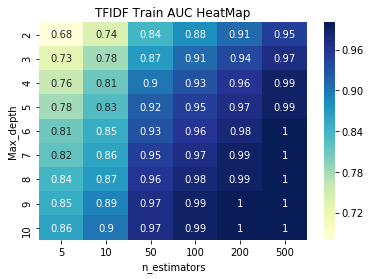

In [234]:
pvt_train = pd.DataFrame(train_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_train,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF Train AUC HeatMap')

In [235]:
cv_auc = np.round(cv_auc,2)
cv_auc_rs = np.reshape(cv_auc,(9,6))
print(cv_auc_rs)

[[0.67 0.74 0.83 0.86 0.89 0.91]
 [0.72 0.77 0.84 0.88 0.9  0.92]
 [0.74 0.79 0.85 0.88 0.9  0.92]
 [0.75 0.79 0.86 0.89 0.91 0.92]
 [0.77 0.79 0.87 0.89 0.91 0.92]
 [0.78 0.8  0.87 0.89 0.91 0.92]
 [0.78 0.81 0.87 0.9  0.91 0.92]
 [0.78 0.81 0.88 0.9  0.91 0.92]
 [0.78 0.81 0.88 0.9  0.91 0.92]]


Text(0.5,1,'TFIDF_Word2Vec CV AUC HeatMap')

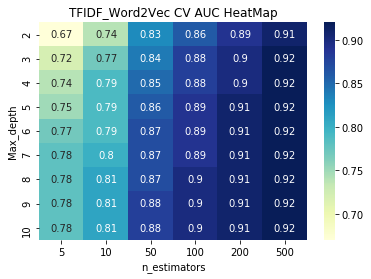

In [236]:
pvt_cv = pd.DataFrame(cv_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_cv,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF_Word2Vec CV AUC HeatMap')

In [246]:
# Fitting the model on test data

xgbm = xgb.XGBClassifier(random_state = 0,n_jobs = 4,max_depth = 5 , n_estimators = 200)
    
# Fitting the model in Train - CrossValidation
xgbm.fit(D2_Train,Y_1_train)
    
predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(xgbm.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(xgbm.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(xgbm.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(xgbm.predict_proba(D2_Train[k:k+1000])[:,1])
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

Algo Run Successfully on D_Test


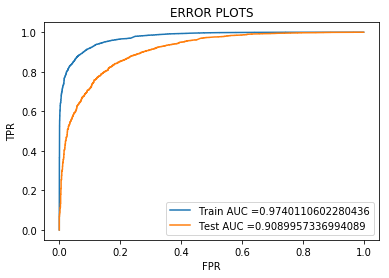

In [247]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [248]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
16721 1279 2216 18092
[[16721  1279]
 [ 2216 18092]]
Test Confusion Matrix
1034 309 778 5362
[[1034  309]
 [ 778 5362]]


Text(0.5,1,'Confusion Matrix of Train Data')

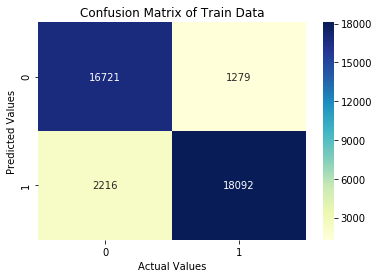

In [249]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

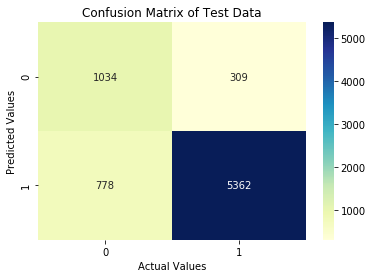

In [250]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

##### Feature Importance

In [251]:
importances = xgbm.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features_tfidf = tfidf_vect.get_feature_names()
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features_tfidf[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[19970 16159  6932  2271 12221  7312 13050 15984  8995 30480 30370  9437
  8100 17453 30565 13188 22748 27233  1574 22416]
        Feature Name  Feature Importance
0            perfect            0.009902
1              loves            0.009026
2          delicious            0.009015
3               best            0.008923
4              great            0.008873
5       disappointed            0.008394
6             highly            0.007656
7               love            0.007562
8          excellent            0.006891
9              worst            0.006886
10         wonderful            0.006871
11          favorite            0.006696
12              easy            0.006663
13             money            0.005866
14  would definitely            0.005727
15          horrible            0.005584
16            return            0.005561
17          terrible            0.004961
18             awful            0.004953
19            refund            0.004944


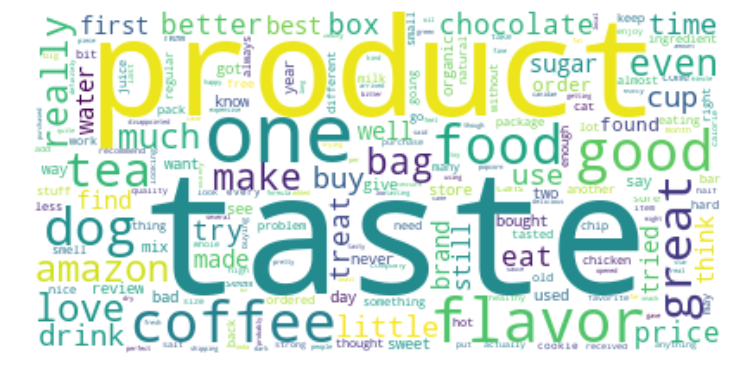

In [252]:
tfidf_features = " ".join(features_tfidf)
word_cloud = WordCloud(background_color="white").generate(tfidf_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 1.3) Applying XGBoost on Word2Vec, SET 3

In [221]:
X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(23945, 2) (23945,)


In [222]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [223]:
df_post_split['Score'].value_counts()

1    20308
0     3637
Name: Score, dtype: int64

In [224]:
# Indicies of each class' observations
i_class0 = np.where(df_post_split['Score'] == 0)[0]
i_class1 = np.where(df_post_split['Score'] == 1)[0]

In [225]:
x_negative_downsample = resample(x_negetive,replace=True,n_samples=18000,random_state=123) 

In [226]:
print(x_negative_downsample.shape, type(x_positive))

(18000, 3) <class 'pandas.core.frame.DataFrame'>


In [227]:
df_upsample = pd.concat([x_positive,x_negative_downsample])
type(df_upsample)
df_upsample.head()

,Cleaned_Text,Word Count,Score
0,really good idea final product outstanding use...,17,1
1,received shipment could hardly wait try produc...,39,1
2,love stuff sugar free rot gums tastes good goi...,12,1
3,nothing product bother link top page buy used ...,16,1
4,fresh limes underappreciated joy kitchen squir...,82,1


In [228]:
df_upsample['Score'].value_counts()

1    20308
0    18000
Name: Score, dtype: int64

In [229]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_1_train = df_upsample['Score']
print(X_Train.shape, Y_1_train.shape)

(38308, 2) (38308,)


In [107]:
# Creating Word2Vec model on Training Data 

list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:10])
print("="*100)

38308


[('great', 0.8118998408317566), ('terrific', 0.740011990070343), ('decent', 0.7183611989021301), ('amazing', 0.7150706052780151), ('terrible', 0.6957366466522217), ('fantastic', 0.694779634475708), ('wonderful', 0.6907916069030762), ('fabulous', 0.6903632879257202), ('bad', 0.6896793842315674), ('awesome', 0.6861222386360168)]
Total Words Present  12970
Sample Words :  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody']


In [108]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 38308/38308 [02:03<00:00, 309.07it/s]


38308
[ 0.22500378  0.02523698  0.06308806 -0.02333992 -0.21590991 -0.31598377
  0.59600934  0.27315611  0.53831612  0.24073695 -0.10470631  0.20739605
 -0.43720947 -0.23464066  0.30156076  0.18378142 -0.3792846  -0.25608248
 -0.42988534  0.32164321  0.01888745  0.44769622  0.80671174 -0.37001823
  0.14022694 -0.33603725 -0.07377699  0.24300447  0.50991106 -0.67871357
 -0.30200357  0.03690891 -0.10505963  0.46987874  0.26909058  0.74780564
 -0.55333254 -0.27250317 -0.27612169 -0.12426214  0.34292279 -0.53004518
  0.38647154  0.07171449  0.48713188 -0.37558757 -0.01134154  0.1746185
  0.19398412 -0.69118824]


In [109]:

list_of_sentence = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

5987


In [110]:
sent_vect_cv = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_cv.append(sentence_vec)
print(len(sent_vect_cv))
print(sent_vect_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 5987/5987 [00:17<00:00, 337.66it/s]


5987
[-0.1656477   0.15279717 -0.14981162 -0.77947596 -0.25191478 -0.28124005
 -0.18269562  0.97330843 -0.38321414 -0.16911353 -0.0798452   0.21667819
 -0.25140917  0.00195684  0.41393985  0.75164548  0.05103608  0.01100275
 -0.11917715  0.05640475 -0.23543895  0.14501098  0.85979928 -0.56715472
 -0.60367716 -0.0803155   0.41887084  0.13785505 -0.011987   -0.48390301
 -0.46511896  0.67200045 -0.17443779  0.33863469 -0.25296665  1.06149271
 -0.51536811  0.0668909  -0.85345936  0.17879572  1.11202332  0.46875294
  0.90581426 -0.50881965  0.21034394 -0.27244642 -0.39041115 -0.2754116
  0.65042712 -0.32467561]


In [111]:
# Applying Word2Vec for Vectorization of X_test

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

7483


In [112]:
# Creating Average Word2Vec Vector for Test Data

sent_vect_test = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_test.append(sentence_vec)
print(len(sent_vect_test))
print(sent_vect_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 7483/7483 [00:22<00:00, 336.33it/s]


7483
[-0.23771112  0.10581948 -0.47181668  0.66409492  0.12713598 -0.9316893
  0.36348048  1.62186388  0.23035716  0.65128752  0.36584222 -0.16501123
 -0.07748719 -0.13513063  0.27351724 -0.62076651 -0.53378994  0.30692838
 -0.51611989 -0.3918791   0.62893962  1.26672972  0.46807039 -0.48719258
  0.92185823  0.06151465 -0.35039031 -0.27661941  0.28298119 -1.34979689
  0.2393189   0.78842906  0.58502624  0.53396648 -0.3050632  -0.02307211
 -0.13359944  0.6144729  -0.87085611 -0.03990829  0.61334443 -0.96962671
  0.45344021  0.11524999 -0.15714369 -0.1448606  -0.33645242 -0.60654196
 -0.13524376 -0.18068661]


In [119]:
n_train = len(sent_vect_train)
n_test = len(sent_vect_test)
n_cv = len(sent_vect_cv)
print(n_train)
print(n_test)

38308
7483


In [120]:
D3_Train = np.array(sent_vect_train)
D3_Cv = np.array(sent_vect_cv)

In [157]:
D3_Test = np.array(sent_vect_test)

In [123]:
# Applying XGBoost

cv_score = []
train_score = []

# creating hyper-parameter list
max_depth = list((2, 3, 4, 5, 6, 7, 8, 9, 10))
n_estimators = list((5, 10, 50, 100, 200, 500))


cv_auc = []
train_auc = []
        
for i in tqdm(max_depth):
    for j in tqdm(n_estimators):
        xgbm = xgb.XGBClassifier(random_state = 0,n_jobs = 4, silent = False, max_depth = i , n_estimators = j)
    
        # Fitting the model in Train - CrossValidation
        xgbm.fit(D3_Train,Y_1_train)
    
        predict_cv_prob = []
        predict_train_prob = []
        
        # Predicting the model with CrossValidation and Train Data
        for j in range(0,n_cv,1000):
            predict_cv_prob.extend(xgbm.predict_proba(D3_Cv[j:j+1000])[:,1])
    
        for k in range(0,n_train,1000):
            predict_train_prob.extend(xgbm.predict_proba(D3_Train[k:k+1000])[:,1])
        
        cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
        train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [37:06<00:00, 331.12s/it]


In [148]:
print(train_auc)

[0.76 0.79 0.86 0.88 0.9  0.92 0.78 0.82 0.89 0.91 0.93 0.96 0.82 0.85
 0.91 0.93 0.96 0.99 0.85 0.87 0.94 0.96 0.98 1.   0.88 0.9  0.96 0.98
 1.   1.   0.91 0.94 0.98 0.99 1.   1.   0.94 0.96 0.99 1.   1.   1.
 0.97 0.98 1.   1.   1.   1.   0.98 0.99 1.   1.   1.   1.  ]


In [149]:
train_auc = np.round(train_auc,2)
print(train_auc)

[0.76 0.79 0.86 0.88 0.9  0.92 0.78 0.82 0.89 0.91 0.93 0.96 0.82 0.85
 0.91 0.93 0.96 0.99 0.85 0.87 0.94 0.96 0.98 1.   0.88 0.9  0.96 0.98
 1.   1.   0.91 0.94 0.98 0.99 1.   1.   0.94 0.96 0.99 1.   1.   1.
 0.97 0.98 1.   1.   1.   1.   0.98 0.99 1.   1.   1.   1.  ]


In [154]:
train_auc_rs = np.reshape(train_auc,(9,6))
print(train_auc_rs)

[[0.76 0.79 0.86 0.88 0.9  0.92]
 [0.78 0.82 0.89 0.91 0.93 0.96]
 [0.82 0.85 0.91 0.93 0.96 0.99]
 [0.85 0.87 0.94 0.96 0.98 1.  ]
 [0.88 0.9  0.96 0.98 1.   1.  ]
 [0.91 0.94 0.98 0.99 1.   1.  ]
 [0.94 0.96 0.99 1.   1.   1.  ]
 [0.97 0.98 1.   1.   1.   1.  ]
 [0.98 0.99 1.   1.   1.   1.  ]]


Text(0.5,1,'TFIDF Train AUC HeatMap')

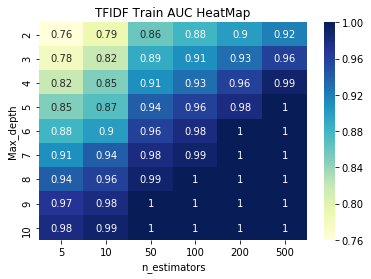

In [156]:
pvt_train = pd.DataFrame(train_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_train,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF Train AUC HeatMap')

In [153]:
cv_auc = np.round(cv_auc,2)
cv_auc_rs = np.reshape(cv_auc,(9,6))
print(cv_auc_rs)

[[0.76 0.78 0.84 0.86 0.87 0.88]
 [0.77 0.81 0.86 0.87 0.87 0.88]
 [0.8  0.82 0.86 0.87 0.88 0.88]
 [0.81 0.83 0.87 0.87 0.88 0.88]
 [0.82 0.84 0.87 0.88 0.88 0.88]
 [0.83 0.85 0.87 0.88 0.88 0.88]
 [0.83 0.85 0.87 0.88 0.88 0.88]
 [0.83 0.85 0.87 0.88 0.88 0.88]
 [0.83 0.85 0.87 0.88 0.88 0.88]]


Text(0.5,1,'Word2Vec Test AUC HeatMap')

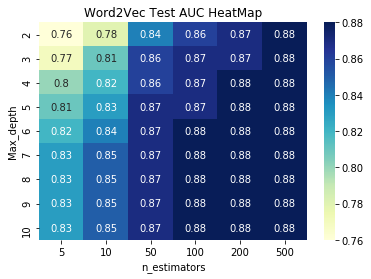

In [147]:
pvt_test = pd.DataFrame(cv_auc_rs,index=max_depth, columns=n_estimators)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
plt.ylabel('Max_depth')
plt.xlabel('n_estimators')
plt.title('Word2Vec Test AUC HeatMap')

In [167]:
# Fitting the model on test data

xgbm = xgb.XGBClassifier(random_state = 0,n_jobs = 4,max_depth = 4 , n_estimators = 200)
    
# Fitting the model in Train - CrossValidation
xgbm.fit(D3_Train,Y_1_train)
    
predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(xgbm.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(xgbm.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(xgbm.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(xgbm.predict_proba(D3_Train[k:k+1000])[:,1])
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

Algo Run Successfully on D_Test


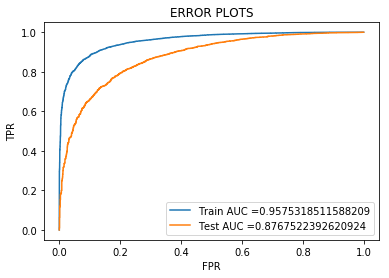

In [168]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [169]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
16146 1854 2335 17973
[[16146  1854]
 [ 2335 17973]]
Test Confusion Matrix
963 380 899 5241
[[ 963  380]
 [ 899 5241]]


Text(0.5,1,'Confusion Matrix of Train Data')

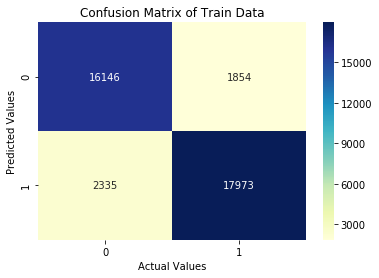

In [170]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

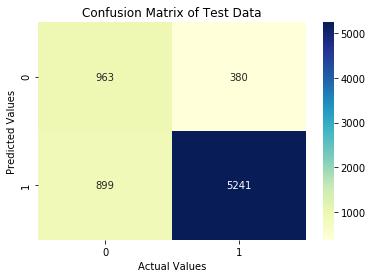

In [171]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

#### Feature Importance

In [172]:
importances = xgbm.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features_w2v = w2v_words
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features_w2v[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[ 0 43 41 30  5  8 37 17  2 13 46 10 36 22 27  7 47 21 11 14]
   Feature Name  Feature Importance
0        really            0.069968
1       screens            0.062720
2          like            0.057990
3       printed            0.043392
4   outstanding            0.041846
5        window            0.034837
6           lot            0.032527
7         could            0.031107
8          idea            0.029155
9           two            0.027942
10        sugar            0.027363
11         asks            0.026486
12        going            0.025372
13         call            0.025150
14     daughter            0.024491
15          car            0.024253
16         free            0.023705
17         love            0.020424
18       bought            0.018680
19       thumbs            0.016126


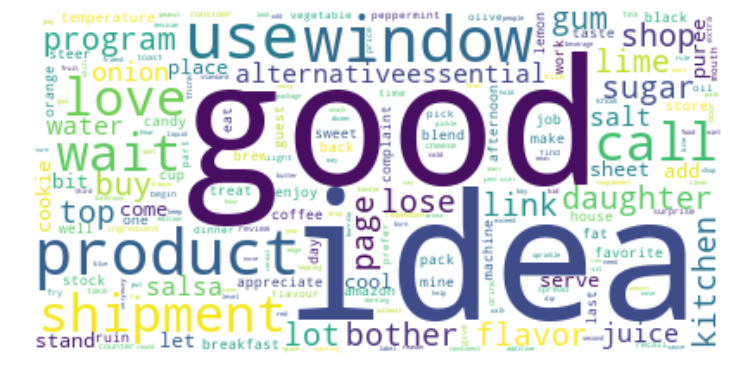

In [173]:
w2v_features = " ".join(features_w2v)
word_cloud = WordCloud(background_color="white").generate(w2v_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 1.4) Applying XGBoost on TFIDF_Word2Vec, SET 4

In [175]:
# Splitting the Training Data into sentences
list_of_sentence_tfidf_w2v = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence_tfidf_w2v.append(sentence.split())
print(len(list_of_sentence_tfidf_w2v))

38308


In [176]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence_tfidf_w2v):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|████████████████████████████████████████████████████████████████████████████| 38308/38308 [34:41<00:00, 18.40it/s]


38308


In [177]:
list_of_sentence_cv = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence_cv.append(sentence.split())
print(len(list_of_sentence_cv))

5987


In [178]:
tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_cv = []
for sent in tqdm(list_of_sentence_cv):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_cv.append(sent_vec)
print(len(tfidf_w2v_cv))

100%|██████████████████████████████████████████████████████████████████████████████| 5987/5987 [04:37<00:00, 21.57it/s]


5987


In [179]:
# Splitting the Test Data into sentences

list_of_sentence_test = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence_test.append(sentence.split())
print(len(list_of_sentence_test))

7483


In [180]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_test = []
for sent in tqdm(list_of_sentence_test):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_test.append(sent_vec)
print(len(tfidf_w2v_test))

100%|██████████████████████████████████████████████████████████████████████████████| 7483/7483 [05:40<00:00, 29.60it/s]


7483


In [181]:
n_train = len(tfidf_w2v_train)
n_test = len(tfidf_w2v_test)
n_cv = len(tfidf_w2v_cv)
print(n_train)
print(n_test)
print(n_cv)

38308
7483
5987


In [182]:
D4_Train = np.array(tfidf_w2v_train)
D4_Cv = np.array(tfidf_w2v_cv)
D4_Test = np.array(tfidf_w2v_test)

In [183]:
# Applying XGBoost

cv_score = []
train_score = []

# creating hyper-parameter list
max_depth = list((2, 3, 4, 5, 6, 7, 8, 9, 10))
n_estimators = list((5, 10, 50, 100, 200, 500))


cv_auc = []
train_auc = []
        
for i in tqdm(max_depth):
    for j in tqdm(n_estimators):
        xgbm = xgb.XGBClassifier(random_state = 0,n_jobs = 4, silent = False, max_depth = i , n_estimators = j)
    
        # Fitting the model in Train - CrossValidation
        xgbm.fit(D4_Train,Y_1_train)
    
        predict_cv_prob = []
        predict_train_prob = []
        
        # Predicting the model with CrossValidation and Train Data
        for j in range(0,n_cv,1000):
            predict_cv_prob.extend(xgbm.predict_proba(D4_Cv[j:j+1000])[:,1])
    
        for k in range(0,n_train,1000):
            predict_train_prob.extend(xgbm.predict_proba(D4_Train[k:k+1000])[:,1])
        
        cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
        train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [29:22<00:00, 252.17s/it]


In [184]:
train_auc = np.round(train_auc,2)
train_auc_rs = np.reshape(train_auc,(9,6))
print(train_auc_rs)

[[0.72 0.76 0.83 0.85 0.88 0.91]
 [0.76 0.79 0.86 0.89 0.91 0.95]
 [0.79 0.82 0.89 0.92 0.95 0.98]
 [0.83 0.85 0.92 0.95 0.98 1.  ]
 [0.86 0.88 0.96 0.98 1.   1.  ]
 [0.9  0.92 0.98 0.99 1.   1.  ]
 [0.93 0.95 0.99 1.   1.   1.  ]
 [0.95 0.97 1.   1.   1.   1.  ]
 [0.97 0.99 1.   1.   1.   1.  ]]


Text(0.5,1,'TFIDF_Word2Vec Train AUC HeatMap')

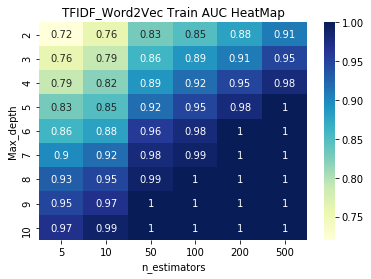

In [185]:
pvt_train = pd.DataFrame(train_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_train,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF_Word2Vec Train AUC HeatMap')

In [186]:
cv_auc = np.round(cv_auc,2)
cv_auc_rs = np.reshape(cv_auc,(9,6))
print(cv_auc_rs)

[[0.72 0.75 0.81 0.83 0.84 0.85]
 [0.75 0.77 0.82 0.84 0.85 0.85]
 [0.77 0.79 0.83 0.84 0.85 0.85]
 [0.78 0.8  0.84 0.85 0.85 0.85]
 [0.79 0.81 0.85 0.85 0.85 0.85]
 [0.79 0.81 0.85 0.85 0.85 0.85]
 [0.8  0.81 0.85 0.85 0.85 0.86]
 [0.79 0.81 0.85 0.85 0.86 0.86]
 [0.79 0.81 0.84 0.85 0.85 0.85]]


Text(0.5,1,'TFIDF_Word2Vec CV AUC HeatMap')

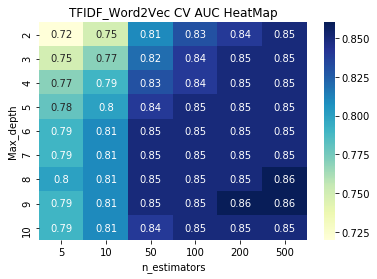

In [187]:
pvt_cv = pd.DataFrame(cv_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_cv,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF_Word2Vec CV AUC HeatMap')

In [216]:
# Fitting the model on test data

xgbm = xgb.XGBClassifier(random_state = 0,n_jobs = 4,max_depth = 4 , n_estimators = 200)
    
# Fitting the model in Train - CrossValidation
xgbm.fit(D4_Train,Y_1_train)
    
predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(xgbm.predict(D4_Test[j:j+1000]))
    predict_test_prob.extend(xgbm.predict_proba(D4_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(xgbm.predict(D4_Train[k:k+1000]))
    predict_train_prob.extend(xgbm.predict_proba(D4_Train[k:k+1000])[:,1])
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

Algo Run Successfully on D_Test


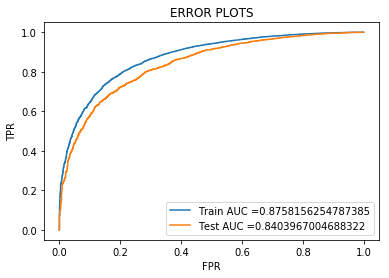

In [217]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [218]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
13862 4138 3773 16535
[[13862  4138]
 [ 3773 16535]]
Test Confusion Matrix
974 369 1298 4842
[[ 974  369]
 [1298 4842]]


Text(0.5,1,'Confusion Matrix of Train Data')

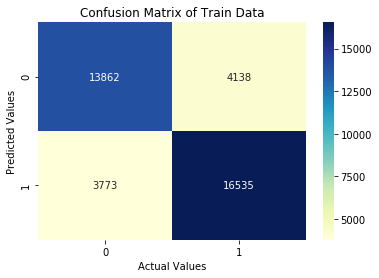

In [219]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

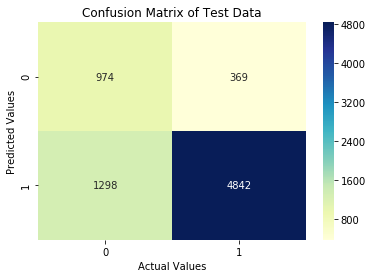

In [220]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

## Conclusion For XGBoost

In [1]:
# Importing Pretty Table
from prettytable import PrettyTable

In [253]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter 1 Value','Hyper-Parameter 2 Value','AUC']
x.add_row(['BOW','Depth = 6','N_Estimators = 500','0.93'])
x.add_row(['Tf-Idf','Depth = 5','N_Estimators = 200','0.91'])
x.add_row(['Average Word2Vec','Depth = 4','N_Estimators = 200','0.88'])
x.add_row(['Tf-Idf_Average_Word2Vec','Depth = 4','N_Estimators = 200','0.84'])

print(x)

+-------------------------+-------------------------+-------------------------+------+
|        Vectorizer       | Hyper-Parameter 1 Value | Hyper-Parameter 2 Value | AUC  |
+-------------------------+-------------------------+-------------------------+------+
|           BOW           |        Depth = 6        |    N_Estimators = 500   | 0.93 |
|          Tf-Idf         |        Depth = 5        |    N_Estimators = 200   | 0.91 |
|     Average Word2Vec    |        Depth = 4        |    N_Estimators = 200   | 0.88 |
| Tf-Idf_Average_Word2Vec |        Depth = 4        |    N_Estimators = 200   | 0.84 |
+-------------------------+-------------------------+-------------------------+------+


## Conclusion 

##### We have sampled top 40k datapoints that are highly imbalanced. We have upsampled only the  training data explicilty. We took 40k data because Xgboost algorithm was taking a lot of time to run on 100k data.

##### We used simple loops to do Cross Validation because Grid Search was taking a lot of time to perform.

##### We have tried to do feature engineering on Bag of Words and Tfidf vectorizer but the performance of the model is decreasing a lot. AUC value decreased rapidly. The confusion matrix became worse with a very less true negative rate and a very high false positive rate. So we didnt go ahead with feature engineering for the final version.
##### Same for Word2Vec and Tfidf_Word2Vec vectorizer. This is the reason we didnt include feature engineering in the final version.
##### We have also performed a feature importance to check if the model is performing good. We have listed the top 20 features along with their weight vector values.
##### We have also visualized Xgboost output of BOW and TFIDF Vectorizer model with Word Cloud.